In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MaxNLocator
import numpy as np
from datetime import datetime

dataset_path = '../data/raw/export_df.parquet'

In [2]:
data = pd.read_parquet(dataset_path)
data.head()

df_copy = data.copy()

Opis kolona:

- datum_dolaska - datum kada bi gost trebao stići u hotel
- datum_kreiranja_rezervacije - datum kada je rezervacija kreirana
- datum_odjave - datum kada je gost napustio hotel
- datum_otkazivanja_rezervacije - datum kada je rezervacija otkazana
- broj_odraslih_gostiju - broj odraslih koji će boraviti u rezerviranim sobama
- broj_djece_gostiju - broj djece koji će boraviti u rezerviranim sobama
- zemlja_gosta - zemlja iz koje gost dolazi. Kategorije su zapisane u ISO 3155–3:2013 formatu
- kanal_prodaje_id - id kanala prodaje preko kojeg je rezervacija napravljena (primjeri: direktna rezervacija, agencija, online)
- tip_sobe_id - id tipa sobe koju je gost rezervirao
- cijena_nocenja - cijena jednog noćenja za pojedinu rezeraciju
- status_rezervacije - status rezervacije (Check-Out, Canceled, No-Show)
- rezervacija_id - id rezervacije
- gost_id - id gosta

In [3]:
hotel_zero = data[data['hotel_id'] == 0]
hotel_one = data[data['hotel_id'] == 1]

assert (len(hotel_zero)+ len(hotel_one)) == len(data)

In [4]:
print(f"Prvi hotel ima {len(hotel_zero)/len(data)*100} % svih zapisa ")
print(f"Drugi hotel ima {len(hotel_one)/len(data)*100} % svih zapisa ")



Prvi hotel ima 33.5936582501468 % svih zapisa 
Drugi hotel ima 66.4063417498532 % svih zapisa 


In [5]:
print(hotel_zero['zemlja_gosta'].value_counts()[0:25])

zemlja_gosta
PRT    17790
GBR     6754
ESP     3937
IRL     2163
FRA     1591
DEU     1217
CN       693
NLD      507
USA      473
0        464
ITA      447
BEL      442
CHE      433
BRA      422
POL      328
SWE      301
AUT      210
RUS      193
ROU      176
FIN      150
CHN      133
NOR      119
AUS       86
LUX       78
MAR       76
Name: count, dtype: int64


In [6]:
print(hotel_one['zemlja_gosta'].value_counts()[0:25])

zemlja_gosta
PRT    32096
FRA     8220
GBR     5738
DEU     5578
ESP     4788
ITA     3120
BEL     1762
BRA     1701
USA     1525
NLD     1525
IRL     1391
CHE     1236
AUT     1000
CHN      820
SWE      686
CN       610
ISR      605
POL      566
NOR      459
RUS      428
DNK      344
AGO      336
AUS      313
ROU      309
FIN      273
Name: count, dtype: int64


In [7]:
df_copy['datum_dolaska'] = pd.to_datetime(df_copy['datum_dolaska'])


df_copy['duljina_boravka'] = df_copy['datum_odjave'] - df_copy['datum_dolaska']
df_copy['duljina_boravka'] = df_copy['duljina_boravka'].dt.days


In [8]:
min_date = df_copy['datum_dolaska'].min()
max_date = df_copy['datum_dolaska'].max()

print(f"Svi zapisi su u razdoblju od {min_date} do {max_date}")

Svi zapisi su u razdoblju od 2015-01-01 00:00:00 do 2017-12-31 00:00:00


### Vizuali

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df_copy['is_cancellation'] = df_copy['datum_otkazivanja_rezervacije'].notna()

grouped_hotel = df_copy.groupby('hotel_id').agg({'is_cancellation': ['sum', 'count']})
grouped_hotel.columns = ['cancellations', 'total_bookings']
grouped_hotel['cancellation_percentage'] = (grouped_hotel['cancellations'] / grouped_hotel['total_bookings']) * 100

grouped_nationality = df_copy.groupby('zemlja_gosta').agg({'is_cancellation': ['sum', 'count']})
grouped_nationality.columns = ['cancellations', 'total_bookings']
grouped_nationality['cancellation_percentage'] = (grouped_nationality['cancellations'] / grouped_nationality['total_bookings']) * 100

grouped_channel = df_copy.groupby('kanal_prodaje_id').agg({'is_cancellation': ['sum', 'count']})
grouped_channel.columns = ['cancellations', 'total_bookings']
grouped_channel['cancellation_percentage'] = (grouped_channel['cancellations'] / grouped_channel['total_bookings']) * 100

In [11]:
print(grouped_nationality['cancellation_percentage'][0:5])


zemlja_gosta
0      17.028986
ABW     0.000000
AGO    55.710306
ALB    27.272727
AND    71.428571
Name: cancellation_percentage, dtype: float64


In [12]:
print(grouped_nationality['cancellations'][0:5])

zemlja_gosta
0       94
ABW      0
AGO    200
ALB      3
AND      5
Name: cancellations, dtype: int64


In [13]:
mean_price_hotel_zero, mean_price_hotel_one  =np.mean(hotel_zero['cijena_nocenja']), np.mean(hotel_one['cijena_nocenja'])
std_price_hotel_zero, std_price_hotel_one  =np.std(hotel_zero['cijena_nocenja']), np.std(hotel_one['cijena_nocenja'])


In [14]:
q11 = np.percentile(hotel_zero['cijena_nocenja'], 25)
q31 = np.percentile(hotel_zero['cijena_nocenja'], 75)
iqr1 = q31 - q11
threshold1 = 1.5 * iqr1
outliers1 = np.where((hotel_zero['cijena_nocenja'] < q11 - threshold1) | (hotel_zero['cijena_nocenja'] > q31 + threshold1))
 
print(len(outliers1[0])/len(hotel_zero['cijena_nocenja'])*100)


7.081679027143107


In [15]:
q12 = np.percentile(hotel_one['cijena_nocenja'], 25)
q32 = np.percentile(hotel_one['cijena_nocenja'], 75)
iqr2 = q31 - q12
threshold2 = 1.5 * iqr2
outliers2 = np.where((hotel_one['cijena_nocenja'] < q12 - threshold2) | (hotel_one['cijena_nocenja'] > q32 + threshold2))
 
print(len(outliers2[0])/len(hotel_one['cijena_nocenja'])*100)


3.0456147442618398


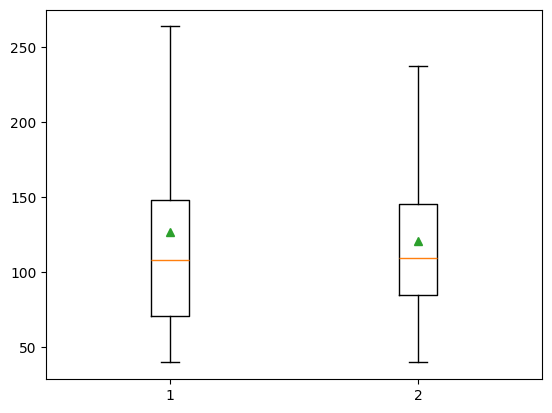

In [16]:
dict = plt.boxplot([hotel_zero['cijena_nocenja'], hotel_one['cijena_nocenja']], showfliers=False,showmeans=True)

### Datumi gdje je datum otkazivanja nakon datuma dolaska

In [17]:
krivi_datumi = df_copy[df_copy['datum_otkazivanja_rezervacije'] > df_copy['datum_dolaska']]
print(f"Ukupno {len(krivi_datumi)} redaka s neispravnim datumima")
print(krivi_datumi.head(3))

Ukupno 1953 redaka s neispravnim datumima
       hotel_id datum_dolaska datum_kreiranja_rezervacije datum_odjave  \
40048         1    2015-01-01                  2015-01-01   2015-01-05   
40054         1    2015-05-02                  2015-01-17   2015-05-06   
40055         1    2015-05-02                  2015-03-28   2015-05-07   

      datum_otkazivanja_rezervacije  broj_odraslih_gostiju  \
40048                    2015-07-01                      2   
40054                    2015-06-25                      1   
40055                    2015-07-02                      2   

       broj_djece_gostiju zemlja_gosta  kanal_prodaje_id  tip_sobe_id  \
40048                 0.0          PRT                 2            1   
40054                 0.0          PRT                 2            1   
40055                 0.0          PRT                 2            1   

       cijena_nocenja status_rezervacije  rezervacija_id  gost_id  \
40048       97.930547           Canceled         1

#### Obrađivanje stupca datum dolaska 

In [18]:
def process_arrival_date(df, years=None):
    df['datum_dolaska'] = pd.to_datetime(df['datum_dolaska'], errors='coerce')

    df['year'] = df['datum_dolaska'].dt.year
    df['month'] = df['datum_dolaska'].dt.month
    df['week'] = df['datum_dolaska'].dt.isocalendar().week.astype(float)
    df['day'] = df['datum_dolaska'].dt.day
    df['dayofweek'] = df['datum_dolaska'].dt.dayofweek
    df['quarter'] = df['datum_dolaska'].dt.quarter
    df['dayofyear'] = df['datum_dolaska'].dt.dayofyear

    if years is not None:
        if not isinstance(years, list):
            years = [years]  
        df = df[df['year'].isin(years)]

    return df


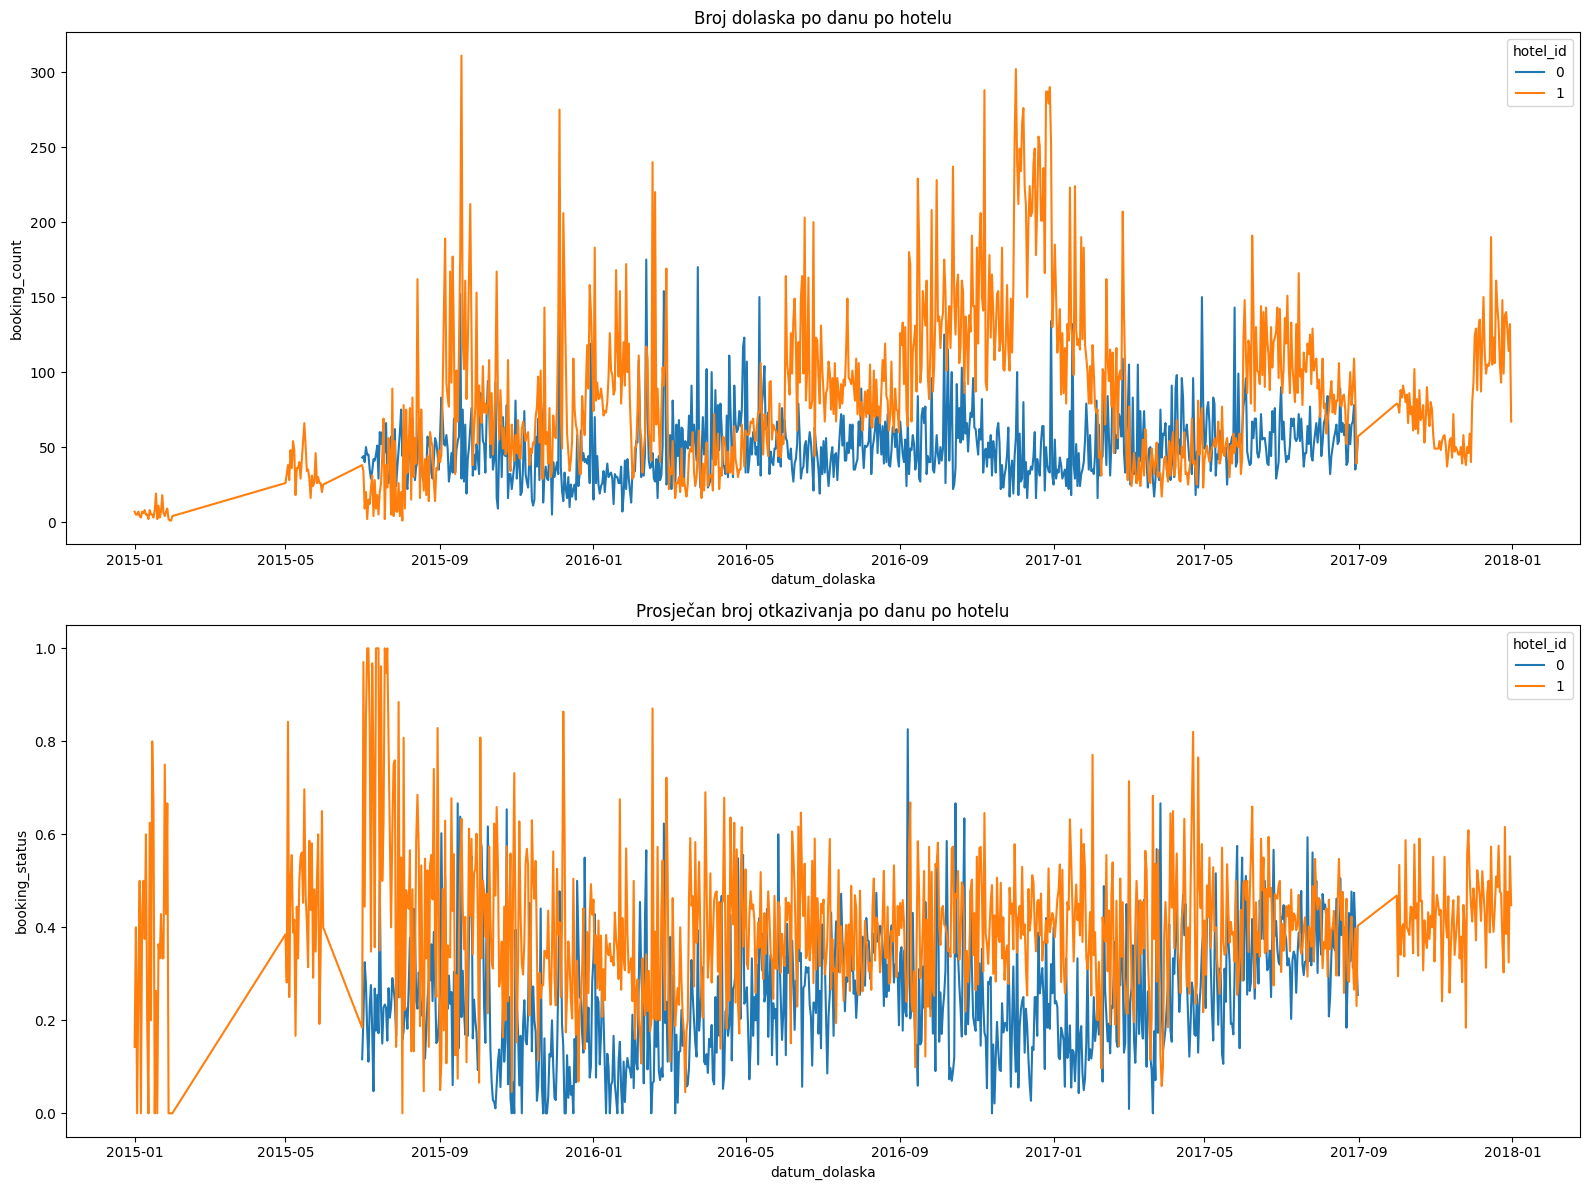

In [19]:
df = process_arrival_date(df_copy)

df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)

dolasci_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id']).size().rename('booking_count').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.lineplot(data=dolasci_po_hotelu,
             x='datum_dolaska',
             y='booking_count',
             hue='hotel_id',
             ax=ax[0]
             )

ax[0].set_title('Broj dolaska po danu po hotelu')

otkazivanja_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id'])['booking_status'].mean().reset_index()

sns.lineplot(data=otkazivanja_po_hotelu,
             x='datum_dolaska',
             y='booking_status',
             hue='hotel_id',
             ax=ax[1]
      )

ax[1].set_title('Prosječan broj otkazivanja po danu po hotelu')

plt.tight_layout()
plt.show()

### Isti vizual samo za 2015


In [20]:
df = process_arrival_date(df_copy,years=[2015])

df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)

dolasci_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id']).size().rename('booking_count').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.lineplot(data=dolasci_po_hotelu,
             x='datum_dolaska',
             y='booking_count',
             hue='hotel_id',
             ax=ax[0]
             )

ax[0].set_title('Broj dolaska po danu po hotelu 2015')

otkazivanja_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id'])['booking_status'].mean().reset_index()

sns.lineplot(data=otkazivanja_po_hotelu,
             x='datum_dolaska',
             y='booking_status',
             hue='hotel_id',
             ax=ax[1]
      )

ax[1].set_title('Prosječan broj otkazivanja po danu po hotelu 2015')

plt.tight_layout()
plt.show()

### Isti vizuali samo za 2016


In [ ]:
df = process_arrival_date(df_copy,years=[2016])

df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)

dolasci_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id']).size().rename('booking_count').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.lineplot(data=dolasci_po_hotelu,
             x='datum_dolaska',
             y='booking_count',
             hue='hotel_id',
             ax=ax[0]
             )

ax[0].set_title('Broj dolaska po danu po hotelu 2016')

otkazivanja_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id'])['booking_status'].mean().reset_index()

sns.lineplot(data=otkazivanja_po_hotelu,
             x='datum_dolaska',
             y='booking_status',
             hue='hotel_id',
             ax=ax[1]
      )

ax[1].set_title('Prosječan broj otkazivanja po danu po hotelu 2016')

plt.tight_layout()
plt.show()

### Isti vizuali samo za 2017


In [ ]:
df = process_arrival_date(df_copy,years=[2017])

df['booking_status'] = df['datum_otkazivanja_rezervacije'].notna().astype(int)

dolasci_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id']).size().rename('booking_count').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

sns.lineplot(data=dolasci_po_hotelu,
             x='datum_dolaska',
             y='booking_count',
             hue='hotel_id',
             ax=ax[0]
             )

ax[0].set_title('Broj dolaska po danu po hotelu 2017')

otkazivanja_po_hotelu = df.groupby(['datum_dolaska', 'hotel_id'])['booking_status'].mean().reset_index()

sns.lineplot(data=otkazivanja_po_hotelu,
             x='datum_dolaska',
             y='booking_status',
             hue='hotel_id',
             ax=ax[1]
      )

ax[1].set_title('Prosječan broj otkazivanja po danu po hotelu 2017')

plt.tight_layout()
plt.show()

In [ ]:
feature_dates = ['day', 'week', 'year', 'quarter']

n_cols = 2
n_rows = math.ceil(len(feature_dates) / n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
ax = ax.flatten()

for i, feature in enumerate(feature_dates):
    sns.countplot(data=df_copy, x=feature, ax=ax[i], color='skyblue')
    ax[i].set_title(f'{feature.capitalize()} Distribution')
    ax[i].set_xlabel(feature.capitalize())
    ax[i].set_ylabel('Count')

    xticks = ax[i].get_xticklabels()
    xticks = [int(float(x.get_text())) for x in xticks if x.get_text()]
    ax[i].set_xticklabels(xticks, rotation=45)

    if len(ax[i].get_xticklabels()) > 10:
        ax[i].xaxis.set_major_locator(MaxNLocator(10))

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
df_copy['duljina_boravka'] = df_copy['datum_odjave'] - df_copy['datum_dolaska']
df_copy['duljina_boravka'] = df_copy['duljina_boravka'].dt.days

In [ ]:
nationality_counts = df_copy['zemlja_gosta'].value_counts()

top_nationalities = nationality_counts.head(8)
top_nationalities['Others'] = nationality_counts[8:].sum()

plt.figure(figsize=(8, 8))
top_nationalities.plot.pie(autopct='%1.1f%%')
plt.title('Distibucija dolaženja po nacionalnosti gostiju')
plt.ylabel('') 


df_copy['nacionalnost'] = df_copy['zemlja_gosta'].apply(lambda x: x if x in nationality_counts.head(8).index.tolist() else 'Others')

plt.figure(figsize=(12, 8))
sns.boxplot(x='nacionalnost', y='duljina_boravka', data=df_copy, palette='Set3')
plt.title('Distribucija duljine boravka po nacionalnosti gostiju')
plt.xlabel('Nacionalnost')
plt.ylabel('Duljina boravka')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()
